The best MAP@7 in private leader board is 0.03140. The worst is 0.00448.

In [60]:
import warnings
warnings.filterwarnings('ignore')

import os
import copy
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

import ml_metrics

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import tensorflow as tf
from tensorflow import keras

In [2]:
def change_dtype_ser(ser):
    
    if ser.dtype == int:
        return ser.astype(np.int32)
    
    if ser.dtype == float:
        return ser.astype(np.float32)
    
    if ser.dtype == np.object:
        return ser.astype("category")
    
    return ser
    

def change_dtype_df(df):
    """
    change types of columns to reduce memory size
    :param df: dataframe
    :return df: dataframe
    """
    memory = df.memory_usage().sum() / 10**6
    print("Memory usage before changing types %0.2f MB" % memory)

    for col in df.columns:
        df[col] = change_dtype_ser(df[col])

    memory = df.memory_usage().sum() / 10 ** 6
    print("Memory usage after changing types %0.2f MB" % memory)
    return df


def load_csv(filename):
    df = pd.read_csv(filename)
    df = change_dtype_df(df)
    return df

In [3]:
class NumImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method="mean"):
        self._method = method
    
    def fit(self, df_train):
        num_cols = df_train.select_dtypes(["number"]).columns.to_list()
        self._train_cols = df_train.columns.to_list()
        
        self._impute_values = {}
        for col in num_cols:
            self._impute_values[col] = df_train[col].agg(self._method)
        return self
    
    def transform(self, df):
        df = df.copy()
        cols = df.columns.to_list()
        assert set(cols) == set(self._train_cols), "Do not have the same set of cols as train"
        
        for col, val in self._impute_values.items():
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(val)
        
        # align columns
        df = df[self._train_cols]
        return df
    

class CatImputer(BaseEstimator, TransformerMixin):
    def __init__(self, val="MISSING"):
        self._val = val
    
    def fit(self, df_train):
        cat_cols = df_train.select_dtypes(["object", "category", "bool"]).columns.to_list()
        self._train_cols = df_train.columns.to_list()
        
        self._impute_values = {}
        for col in cat_cols:
            self._impute_values[col] = self._val
        return self
    
    def transform(self, df):
        df = df.copy()
        cols = df.columns.to_list()
        assert set(cols) == set(self._train_cols), "Do not have the same set of cols as train"
        
        for col, val in self._impute_values.items():
            if df[col].isnull().sum() > 0:
                df[col] = df[col].astype("object").fillna(val).astype("category")
                
        # align columns
        df = df[self._train_cols]
        return df

In [17]:
class UDOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, max_classes=20, to_array=False):
        self._to_array = to_array
        self._max_classes = max_classes
        
    def fit(self, train_df):
        self._cols_before = train_df.columns.to_list()
        
        df_cat = train_df.select_dtypes(["object", "category"])
        self._cat_cols = df_cat.columns.to_list()
        
        self._cat_cols = [col for col in self._cat_cols if train_df[col].nunique() <= self._max_classes]
        #print("Columns to one-hot encode:", self._cat_cols)
        df_cat = train_df[self._cat_cols]
        
        if len(self._cat_cols) > 0:
            self._cat_cols_ohe = pd.get_dummies(df_cat, drop_first=True).columns.to_list()
        else:
            self._cat_cols_ohe = []
        
        num_cols = [col for col in train_df.columns if col not in self._cat_cols]
        self._cols_after = num_cols + self._cat_cols_ohe
        
        return self
    
    def transform(self, df):
        df = df.copy()
        
        cols_before = df.columns.to_list()
        assert set(cols_before) == set(self._cols_before), "Do not have the same columns as train before transformed"
        
        if len(self._cat_cols) == 0:
            print("No cat cols in df_train, so do nothing.")
            return df[self._cols_after]
        
        df_cat = df[self._cat_cols]
        #print("df_cat.columns", df_cat.columns)
        
        # one-hot encode
        df_cat = pd.get_dummies(df_cat)
        # drop cols that are present in test_df but absent in train_df
        cols_to_drop = [col for col in df_cat.columns if col not in self._cat_cols_ohe]
        #print("cols_to_drop:", cols_to_drop)
        df_cat = df_cat.drop(cols_to_drop, axis="columns")
        
        # change to float32
        for col in df_cat.columns:
            df_cat[col] = df_cat[col].astype("float32")
        
        # if some some colums are absent in test but present in train, make them all zero 
        cat_cols_ohe = df_cat.columns.to_list()
        for col in self._cat_cols_ohe:
            if col not in cat_cols_ohe:
                df_cat[col] = 0
                df_cat[col] = df_cat[col].astype(np.uint8)
        
        num_cols = [col for col in df.columns if col not in self._cat_cols]
        cols_after = num_cols + df_cat.columns.to_list()
        assert set(cols_after) == set(self._cols_after), "Do not have the same columns as train after transformed"
        
        df_num = df[num_cols]
        
        df = pd.concat([df_num, df_cat], axis="columns")
        # align columns
        df = df[self._cols_after]
        self._features = df.columns.to_list()
        
        if self._to_array:
            return df.values.astype(np.float32)
        else:
            return df


class UDLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, to_array=False):
        self._to_array = to_array
    
    def fit(self, df_train):
        self._train_cols = df_train.columns.to_list()
        cat_cols = df_train.select_dtypes(["category", "object"]).columns.to_list()
        
        self._cat_col_idx = [i for i, col in enumerate(self._train_cols) if col in cat_cols]
        
        self._label_maps = {}
        self._missing_imputers = {}
        for col in cat_cols:
            label = df_train[col].unique()
            self._label_maps[col] = {c: n for n, c in enumerate(label)}
            
            mode_label = df_train[col].mode().iloc[0]
            self._missing_imputers[col] = self._label_maps[col][mode_label]
        
        #print("Cols to label encode:", list(self._label_maps.keys()))
        return self
    
    def transform(self, df):
        df = df.copy()
        cols = df.columns.to_list()
        assert set(cols) == set(self._train_cols), "do not have the same set of columns as train"
        
        for col, label_map in self._label_maps.items():
            df[col] = df[col].map(label_map).astype(np.float32)
            if df[col].isnull().any():
                df[col] = df[col].astype(np.float32).fillna(self._missing_imputers[col])
        
        # align columns
        df = df[self._train_cols]
        
        self._features = df.columns.to_list()
        if self._to_array:
            return df.values.astype(np.float32)
        else:
            return df
        
    def get_cat_cols(self):
        return self._cat_col_idx

In [5]:
def check_same_cols(df1, df2):
    cols1 = df1.columns
    cols2 = df2.columns
    for c1, c2 in zip(cols1, cols2):
        if c1 != c2:
            print(c1, c2)
    return None

def col_align(df1, df2, to_array=False):
    cols1 = df1.columns.to_list()
    cols2 = df2.columns.to_list()
    assert set(cols1) == set(cols2), "df1 and df2 do not have the same set of columns"
    
    if to_array:
        return df1.values.astype(np.float32), df2[cols1].values.astype(np.float32)
    else:
        return df1, df2[cols1]

In [6]:
# mean average precision at k
def mapk(y, y_prob, k=7):
    y = y[:, np.newaxis]
    # ascending
    y_pred = np.argsort(y_prob, axis=1)
    # descending
    y_pred = y_pred[:, ::-1]
    
    return ml_metrics.mapk(y, y_pred, k=k)

In [7]:
def write_submit(y_prob, target_labels, ncodpers, filepath, k=7):
    # ascending
    y_pred = np.argsort(y_prob, axis=1)
    # descending
    y_pred = y_pred[:, ::-1]
    # cut a k
    y_pred = y_pred[:, :k]
    
    added_prods = target_labels[y_pred]
    added_prods = [" ".join(line) for line in added_prods]
    
    sub_df = pd.DataFrame(ncodpers)
    sub_df["added_products"] = added_prods
    
    sub_df.to_csv(filepath, index=False)
    return None

In [8]:
def whole_to_int(a_dict):
    new_dict = copy.deepcopy(a_dict)
    for k, v in new_dict.items():
        if np.isclose(np.round(v), v):
            new_dict[k] = int(new_dict[k])
    return new_dict


def run_hyperopt(classifier,
                 params_tuned, 
                 X_train, y_train,
                 X_val, y_val,
                 num_eval,
                 metric,
                 params_fixed=None,
                 rstate=None):
    assert metric in ["map7", "acc"]
    
    time_start = time.time()
    if params_fixed is None:
        params_fixed = {"n_jobs": 20, "n_estimators": 100}
    
    def objective_map7(params):
        classifier.set_params(**params_fixed, **params)
        classifier.fit(X_train, y_train)
        
        y_val_prob = classifier.predict_proba(X_val)
        map7 = mapk(y_val, y_val_prob, k=7)
        
        return {"loss": -map7, "status": STATUS_OK}
    
    def objective_acc(params):
        classifier.set_params(**params_fixed, **params)
        classifier.fit(X_train, y_train)
        
        y_val_pred = classifier.predict(X_val)
        acc = accuracy_score(y_val, y_val_pred)
        
        return {"loss": -acc, "status": STATUS_OK}
    
    if metric == "map7":
        print("Use map7")
        objective = objective_map7
    else:
        print("Use acc")
        objective = objective_acc
    
    if rstate is not None:
        rstate = np.random.RandomState(rstate)
        
    trials = Trials()
    best_params = fmin(objective, 
                      params_tuned, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate=rstate)
    
    best_params = whole_to_int(best_params)
    
    time_end = time.time()
    time_elapse = time_end - time_start
    print("Time elapsed: %0.5f s" % time_elapse)
    
    return trials, best_params

In [9]:
INP_DIR = "data/data1_"
SUB_DIR = "data/submit_"

In [10]:
X_y_train_df = load_csv(os.path.join(INP_DIR, "X_y_train.csv"))
X_y_val_df = load_csv(os.path.join(INP_DIR, "X_y_val.csv"))
X_test_df = load_csv(os.path.join(INP_DIR, "X_test.csv"))

X_y_train_df.shape, X_y_val_df.shape, X_test_df.shape

Memory usage before changing types 1036.11 MB
Memory usage after changing types 497.64 MB
Memory usage before changing types 101.92 MB
Memory usage after changing types 48.92 MB
Memory usage before changing types 2632.67 MB
Memory usage after changing types 1267.08 MB


((364826, 355), (35887, 355), (929615, 354))

# Predict with most popular products

In [11]:
def predict_popular_prods(y_train, X_test, out_filepath):
    seven_most_popul = y_train.value_counts().index[:7].to_list()
    seven_most_popul = " ".join(seven_most_popul)
    
    sub_df = X_test[["ncodpers"]].copy()
    sub_df["added_products"] = seven_most_popul
    
    sub_df.to_csv(out_filepath, index=False)
    return None

In [12]:
out_filepath = os.path.join(SUB_DIR, "popula_prods.csv")

# submiting this gives MAP@7 = 0.01580 for public and MAP@7 = 0.01589 for private score.
predict_popular_prods(X_y_train_df["TARGET"], X_test_df, out_filepath)

# Logistic Regression

In [13]:
X_train = X_y_train_df.drop(["ncodpers", "TARGET"], axis=1)
print("X_train.shape", X_train.shape)
y_train = X_y_train_df["TARGET"]
print("y_train.shape", y_train.shape)

X_val = X_y_val_df.drop(["ncodpers", "TARGET"], axis=1)
print("X_val.shape", X_val.shape)
y_val = X_y_val_df["TARGET"]
print("y_val.shape", y_val.shape)

X_test = X_test_df.drop(["ncodpers"], axis=1)
print("X_test.shape", X_test.shape)
ncodpers_test = X_test_df["ncodpers"]


le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)

target_classes = le.classes_

print("Impute numerical cols")
num_imputer = NumImputer()
num_imputer.fit(X_train)
X_train = num_imputer.transform(X_train)
X_val = num_imputer.transform(X_val)
X_test = num_imputer.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("Impute cat cols")
cat_imputer = CatImputer()
cat_imputer.fit(X_train)
X_train = cat_imputer.transform(X_train)
X_val = cat_imputer.transform(X_val)
X_test = cat_imputer.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("One-hot encoding")
udohe = UDOneHotEncoder()
udohe.fit(X_train)
X_train = udohe.transform(X_train)
X_val = udohe.transform(X_val)
X_test = udohe.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("Label encoding")
ud_le = UDLabelEncoder()
ud_le.fit(X_train)
X_train = ud_le.transform(X_train)
X_val = ud_le.transform(X_val)
X_test = ud_le.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


X_train.shape, X_val.shape, X_test.shape

X_train.shape (364826, 353)
y_train.shape (364826,)
X_val.shape (35887, 353)
y_val.shape (35887,)
X_test.shape (929615, 353)
Impute numerical cols
(364826, 353) (35887, 353) (929615, 353)
Impute cat cols
(364826, 353) (35887, 353) (929615, 353)
One-hot encoding
(364826, 388) (35887, 388) (929615, 388)
Label encoding
(364826, 388) (35887, 388) (929615, 388)


((364826, 388), (35887, 388), (929615, 388))

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [18]:
y_train_pred = lr.predict(X_train)
y_train_prob = lr.predict_proba(X_train)

y_val_pred = lr.predict(X_val)
y_val_prob = lr.predict_proba(X_val)

acc_train = accuracy_score(y_train, y_train_pred)
print("Train acc: %0.4f" %acc_train)
acc_val = accuracy_score(y_val, y_val_pred)
print("Validation acc: %0.4f" %acc_val)

map7_train = mapk(y_train, y_train_prob, k=7)
print("Train MAP@7: %0.4f" %map7_train)
map7_val = mapk(y_val, y_val_prob, k=7)
print("Validation MAP@7: %0.4f" %map7_val)

Train acc: 0.6251
Validation acc: 0.6335
Train MAP@7: 0.7746
Validation MAP@7: 0.7782


## Predict for `2016-06`

In [27]:
lr = LogisticRegression()
lr.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

y_train_pred = lr.predict(X_train)
y_train_prob = lr.predict_proba(X_train)

y_test_pred = lr.predict(X_test)
y_test_prob = lr.predict_proba(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
print("Train acc: %0.4f" %acc_train)

map7_train = mapk(y_train, y_train_prob, k=7)
print("Train MAP@7: %0.4f" %map7_train)


# submiting this gives MAP@7 = 0.02662 for public and MAP@7 = 0.02687 for private score.
write_submit(y_test_prob, target_classes, ncodpers_test, 
             os.path.join(SUB_DIR, "lr_d1.csv"), k=7)

Train acc: 0.6248
Train MAP@7: 0.7749


# Random Forest

In [12]:
X_train = X_y_train_df.drop(["ncodpers", "TARGET"], axis=1)
print("X_train.shape", X_train.shape)
y_train = X_y_train_df["TARGET"]
print("y_train.shape", y_train.shape)

X_val = X_y_val_df.drop(["ncodpers", "TARGET"], axis=1)
print("X_val.shape", X_val.shape)
y_val = X_y_val_df["TARGET"]
print("y_val.shape", y_val.shape)

X_test = X_test_df.drop(["ncodpers"], axis=1)
print("X_test.shape", X_test.shape)
ncodpers_test = X_test_df["ncodpers"]


le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)

target_classes = le.classes_

print("Impute numerical cols")
num_imputer = NumImputer()
num_imputer.fit(X_train)
X_train = num_imputer.transform(X_train)
X_val = num_imputer.transform(X_val)
X_test = num_imputer.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("Impute cat cols")
cat_imputer = CatImputer()
cat_imputer.fit(X_train)
X_train = cat_imputer.transform(X_train)
X_val = cat_imputer.transform(X_val)
X_test = cat_imputer.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("One-hot encoding")
udohe = UDOneHotEncoder()
udohe.fit(X_train)
X_train = udohe.transform(X_train)
X_val = udohe.transform(X_val)
X_test = udohe.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("Label encoding")
ud_le = UDLabelEncoder(to_array=True)
ud_le.fit(X_train)
X_train = ud_le.transform(X_train)
X_val = ud_le.transform(X_val)
X_test = ud_le.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


X_train.shape, X_val.shape, X_test.shape

X_train.shape (364826, 353)
y_train.shape (364826,)
X_val.shape (35887, 353)
y_val.shape (35887,)
X_test.shape (929615, 353)
Impute numerical cols
(364826, 353) (35887, 353) (929615, 353)
Impute cat cols
(364826, 353) (35887, 353) (929615, 353)
One-hot encoding
(364826, 388) (35887, 388) (929615, 388)
Label encoding
(364826, 388) (35887, 388) (929615, 388)


((364826, 388), (35887, 388), (929615, 388))

In [ ]:
# this runs too slowly
params = {
    "max_depth": scope.int(hp.quniform("max_depth", 2, 30, 2)),
    "min_samples_split": scope.int(hp.quniform("min_samples_split", 10, 500, 20)),
    "min_samples_leaf": scope.int(hp.quniform("min_samples_leaf", 5, 200, 10)), 
    "max_features": scope.int(hp.quniform("max_features", 20, 300, 10)),
}

params_fixed = {
    "n_jobs": 20,
    "n_estimators": 500
}

num_eval = 100
metric = "map7"
rf = RandomForestClassifier()

trials, best_params = run_hyperopt(rf, params, 
                                   X_train, y_train, X_val, y_val, 
                                   num_eval, metric,
                                   params_fixed=params_fixed)
best_params

In [ ]:
rf = RandomForestClassifier(**params_fixed, **best_params)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)

y_val_pred = rf.predict(X_val)
y_val_prob = rf.predict_proba(X_val)

acc_train = accuracy_score(y_train, y_train_pred)
print("Train acc: %0.4f" %acc_train)
acc_val = accuracy_score(y_val, y_val_pred)
print("Validation acc: %0.4f" %acc_val)

map7_train = mapk(y_train, y_train_prob, k=7)
print("Train MAP@7: %0.4f" %map7_train)
map7_val = mapk(y_val, y_val_prob, k=7)
print("Validation MAP@7: %0.4f" %map7_val)

### Predict for `2016-06`

In [13]:
params_fixed = {
    "n_jobs": 20,
    "n_estimators": 1000
}

best_params = {}

In [14]:
rf = RandomForestClassifier(**params_fixed, **best_params)
rf.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))


y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)

y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
print("Train acc: %0.4f" %acc_train)

map7_train = mapk(y_train, y_train_prob, k=7)
print("Train MAP@7: %0.4f" %map7_train)


# submiting this gives MAP@7 = 0.02758 for public and MAP@7 = 0.02799 for private score.
write_submit(y_test_prob, target_classes, ncodpers_test, 
             os.path.join(SUB_DIR, "rf_d1.csv"), k=7)

Train acc: 0.7953
Train MAP@7: 0.8915


# XGBoost

In [11]:
X_train = X_y_train_df.drop(["ncodpers", "TARGET"], axis=1)
print("X_train.shape", X_train.shape)
y_train = X_y_train_df["TARGET"]
print("y_train.shape", y_train.shape)

X_val = X_y_val_df.drop(["ncodpers", "TARGET"], axis=1)
print("X_val.shape", X_val.shape)
y_val = X_y_val_df["TARGET"]
print("y_val.shape", y_val.shape)

X_test = X_test_df.drop(["ncodpers"], axis=1)
print("X_test.shape", X_test.shape)
ncodpers_test = X_test_df["ncodpers"]


le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)

target_classes = le.classes_

print("Impute numerical cols")
num_imputer = NumImputer()
num_imputer.fit(X_train)
X_train = num_imputer.transform(X_train)
X_val = num_imputer.transform(X_val)
X_test = num_imputer.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("Impute cat cols")
cat_imputer = CatImputer()
cat_imputer.fit(X_train)
X_train = cat_imputer.transform(X_train)
X_val = cat_imputer.transform(X_val)
X_test = cat_imputer.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("One-hot encoding")
udohe = UDOneHotEncoder()
udohe.fit(X_train)
X_train = udohe.transform(X_train)
X_val = udohe.transform(X_val)
X_test = udohe.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("Label encoding")
ud_le = UDLabelEncoder(to_array=True)
ud_le.fit(X_train)
X_train = ud_le.transform(X_train)
X_val = ud_le.transform(X_val)
X_test = ud_le.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


X_train.shape, X_val.shape, X_test.shape

X_train.shape (364826, 353)
y_train.shape (364826,)
X_val.shape (35887, 353)
y_val.shape (35887,)
X_test.shape (929615, 353)
Impute numerical cols
(364826, 353) (35887, 353) (929615, 353)
Impute cat cols
(364826, 353) (35887, 353) (929615, 353)
One-hot encoding
(364826, 388) (35887, 388) (929615, 388)
Label encoding
(364826, 388) (35887, 388) (929615, 388)


((364826, 388), (35887, 388), (929615, 388))

In [12]:
params = {
    "max_depth": scope.int(hp.quniform("max_depth", 2, 14, 1)),
    "min_child_weight": scope.int(hp.quniform("min_child_weight", 1, 20, 1)), 
    "subsample": hp.uniform("subsample", 0.4, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 1.0),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.000001), np.log(100)),
    #"reg_alpha": hp.loguniform("reg_alpha", np.log(0.001), np.log(1000)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.001), np.log(1.)),
    #"gamma": hp.uniform("gamma", 0., 5.),
}

params_fixed = {
    "objective": "multi:softmax",
    "booster": "gbtree",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "n_estimators": 500
}

num_eval = 50
metric = "map7"
xgb = XGBClassifier()
trials, best_params = run_hyperopt(xgb, params, 
                                   X_train, y_train, X_val, y_val, 
                                   num_eval, metric,
                                   params_fixed=params_fixed)
best_params

Use map7
100%|██████████| 50/50 [17:50:39<00:00, 1284.80s/trial, best loss: -0.7876664450716335]  
Time elapsed: 64239.86104 s


{'colsample_bytree': 0.8714541979195253,
 'learning_rate': 0.01839666166429914,
 'max_depth': 11,
 'min_child_weight': 12,
 'reg_lambda': 0.0001365632931605928,
 'subsample': 0.913070589798433}

In [ ]:
{'colsample_bytree': 0.8714541979195253,
 'learning_rate': 0.01839666166429914,
 'max_depth': 11,
 'min_child_weight': 12,
 'reg_lambda': 0.0001365632931605928,
 'subsample': 0.913070589798433}

In [13]:
xgb = XGBClassifier(**params_fixed, **best_params)
xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_train_prob = xgb.predict_proba(X_train)

y_val_pred = xgb.predict(X_val)
y_val_prob = xgb.predict_proba(X_val)

acc_train = accuracy_score(y_train, y_train_pred)
print("Train acc: %0.4f" %acc_train)
acc_val = accuracy_score(y_val, y_val_pred)
print("Validation acc: %0.4f" %acc_val)

map7_train = mapk(y_train, y_train_prob, k=7)
print("Train MAP@7: %0.4f" %map7_train)
map7_val = mapk(y_val, y_val_prob, k=7)
print("Validation MAP@7: %0.4f" %map7_val)

Train acc: 0.6606
Validation acc: 0.6475
Train MAP@7: 0.7980
Validation MAP@7: 0.7877


### Predict for `2016-06`

In [14]:
xgb = XGBClassifier(**params_fixed, **best_params)
xgb.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

y_train_pred = xgb.predict(X_train)
y_train_prob = xgb.predict_proba(X_train)

y_test_pred = xgb.predict(X_test)
y_test_prob = xgb.predict_proba(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
print("Train acc: %0.4f" %acc_train)

map7_train = mapk(y_train, y_train_prob, k=7)
print("Train MAP@7: %0.4f" %map7_train)


# submiting this gives MAP@7 = 0.02870 for public and MAP@7 = 0.02899 for private score.
write_submit(y_test_prob, target_classes, ncodpers_test, 
             os.path.join(SUB_DIR, "xgb_d1.csv"), k=7)

Train acc: 0.6596
Train MAP@7: 0.7978


# Neural network

In [75]:
X_train = X_y_train_df.drop(["ncodpers", "TARGET"], axis=1)
print("X_train.shape", X_train.shape)
y_train = X_y_train_df[["TARGET"]]
print("y_train.shape", y_train.shape)

X_val = X_y_val_df.drop(["ncodpers", "TARGET"], axis=1)
print("X_val.shape", X_val.shape)
y_val = X_y_val_df[["TARGET"]]
print("y_val.shape", y_val.shape)

X_test = X_test_df.drop(["ncodpers"], axis=1)
print("X_test.shape", X_test.shape)
ncodpers_test = X_test_df["ncodpers"]


ohe = OneHotEncoder()
ohe.fit(y_train)
y_train = ohe.transform(y_train).toarray()
y_val = ohe.transform(y_val).toarray()

target_classes = ohe.categories_[0]


print("Impute numerical cols")
num_imputer = NumImputer()
num_imputer.fit(X_train)
X_train = num_imputer.transform(X_train)
X_val = num_imputer.transform(X_val)
X_test = num_imputer.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("Impute cat cols")
cat_imputer = CatImputer()
cat_imputer.fit(X_train)
X_train = cat_imputer.transform(X_train)
X_val = cat_imputer.transform(X_val)
X_test = cat_imputer.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("One-hot encoding")
udohe = UDOneHotEncoder()
udohe.fit(X_train)
X_train = udohe.transform(X_train)
X_val = udohe.transform(X_val)
X_test = udohe.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


print("Label encoding")
ud_le = UDLabelEncoder()
ud_le.fit(X_train)
X_train = ud_le.transform(X_train)
X_val = ud_le.transform(X_val)
X_test = ud_le.transform(X_test)
print(X_train.shape, X_val.shape, X_test.shape)


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


X_train.shape, X_val.shape, X_test.shape

X_train.shape (364826, 353)
y_train.shape (364826, 1)
X_val.shape (35887, 353)
y_val.shape (35887, 1)
X_test.shape (929615, 353)
Impute numerical cols
(364826, 353) (35887, 353) (929615, 353)
Impute cat cols
(364826, 353) (35887, 353) (929615, 353)
One-hot encoding
(364826, 388) (35887, 388) (929615, 388)
Label encoding
(364826, 388) (35887, 388) (929615, 388)


((364826, 388), (35887, 388), (929615, 388))

In [57]:
keras.backend.clear_session()

input_shape = X_train.shape[-1:]
output_shape = y_train.shape[-1]

model = keras.models.Sequential()
model.add(keras.layers.Dense(100, input_shape=input_shape, activation="elu", kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(output_shape, activation="softmax"))


optimizer = keras.optimizers.Adam(lr=5e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               38900     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 22)                2222      
Total params: 61,322
Trainable params: 61,322
Non-trainable params: 0
_________________________________________________________________


In [58]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_acc", mode="max", 
                                                  restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping_cb])

Epoch 1/100
5701/5701 [==============================] - 25s 4ms/step - loss: 1.1126 - acc: 0.6139 - val_loss: 0.9919 - val_acc: 0.6322
Epoch 2/100
5701/5701 [==============================] - 24s 4ms/step - loss: 1.0347 - acc: 0.6295 - val_loss: 0.9847 - val_acc: 0.6355
Epoch 3/100
5701/5701 [==============================] - 25s 4ms/step - loss: 1.0175 - acc: 0.6325 - val_loss: 0.9789 - val_acc: 0.6348
Epoch 4/100
5701/5701 [==============================] - 25s 4ms/step - loss: 1.0064 - acc: 0.6353 - val_loss: 0.9820 - val_acc: 0.6397
Epoch 5/100
5701/5701 [==============================] - 25s 4ms/step - loss: 0.9994 - acc: 0.6359 - val_loss: 0.9710 - val_acc: 0.6423
Epoch 6/100
5701/5701 [==============================] - 25s 4ms/step - loss: 0.9930 - acc: 0.6367 - val_loss: 0.9730 - val_acc: 0.6389
Epoch 7/100
5701/5701 [==============================] - 24s 4ms/step - loss: 0.9882 - acc: 0.6372 - val_loss: 0.9810 - val_acc: 0.6343
Epoch 8/100
5701/5701 [=========================

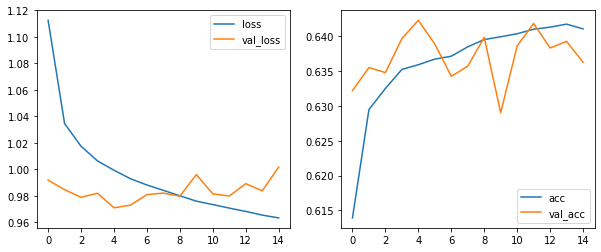

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(history.history["loss"], label="loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].legend()

ax[1].plot(history.history["acc"], label="acc")
ax[1].plot(history.history["val_acc"], label="val_acc")
ax[1].legend()

In [78]:
_, acc_train = model.evaluate(X_train, y_train, verbose=0)
print("Train acc: %0.4f" %acc_train)
_, acc_val = model.evaluate(X_val, y_val, verbose=0)
print("Validation acc: %0.4f" %acc_val)

y_train_prob = model.predict(X_train)
y_val_prob = model.predict(X_val)

map7_train = mapk(np.argmax(y_train, axis=1), y_train_prob, k=7)
print("Train MAP@7: %0.4f" %map7_train)
map7_val = mapk(np.argmax(y_val, axis=1), y_val_prob, k=7)
print("Validation MAP@7: %0.4f" %map7_val)

Train acc: 0.6377
Validation acc: 0.6423
Train MAP@7: 0.7830
Validation MAP@7: 0.7828


### Predict for `2016-06`

In [79]:
y_test_prob = model.predict(X_test)

# submiting this gives MAP@7 = 0.02752 for public and MAP@7 = 0.02768 for private score.
write_submit(y_test_prob, target_classes, ncodpers_test, 
             os.path.join(SUB_DIR, "nn_d1.csv"), k=7)